In [2]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP, MORCGP_shared_noise, MOGPRegressor_NC_bounded_noise, MORCGP_bounded_noise, MOGPRegressor_bounded_noises, MORCGP_bounded_noises
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=3, suppress=True)

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 22,   
    'ytick.labelsize': 22,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [4]:
dfs = pd.read_excel(r'FNCL 28-8 11-09.xlsx', sheet_name=["FNCL 5 9 25", "FNCL 5.5 9 25", "FNCL 6 9 25"])
# df_fncl5, df_fncl5_5, df_fncl6 =
df_fncl5 = dfs["FNCL 5 9 25"]
df_fncl5_5 = dfs["FNCL 5.5 9 25"]
df_fncl6 = dfs["FNCL 6 9 25"]
df_fncl5

,Date,Last Price
0,2025-09-11 21:56:36,99-26
1,2025-09-11 21:56:36,99-26
2,2025-09-11 21:56:36,99-26
3,2025-09-11 21:56:36,99-26
4,2025-09-11 20:51:44,99-27+
...,...,...
1875,2025-08-28 13:12:02,98-20
1876,2025-08-28 13:02:02,98-19+
1877,2025-08-28 13:02:02,98-19
1878,2025-08-28 13:02:02,98-19+


In [5]:
def preprocess_data(dfs, securities, target_dates):
    df_fncl5 = dfs["FNCL 5 9 25"]
    df_fncl5_5 = dfs["FNCL 5.5 9 25"]
    df_fncl6 = dfs["FNCL 6 9 25"]

    # Only consider last price for same timestamp
    def process_last_price(df):
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by=['Date'])
        result = df.groupby('Date', as_index=False).last()
        return result
    fncl5_last_price = process_last_price(df_fncl5)
    fncl5_5_last_price = process_last_price(df_fncl5_5)
    fncl6_last_price = process_last_price(df_fncl6)

    # Process bloomberg format to numeric
    def parse_bloomberg_price(price) -> float:
        if pd.isna(price):
            return None
        price_str = str(price)
        if "-" not in price_str:
            return float(price_str)
        whole, frac = price_str.split("-")
        whole = int(whole)
        if frac.endswith("+"):
            frac_val = int(frac[:-1]) + 0.5
        else:
            frac_val = int(frac)
        return whole + frac_val / 32.0
    fncl5_last_price["Last Price"] = fncl5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl5_5_last_price["Last Price"] = fncl5_5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl6_last_price["Last Price"] = fncl6_last_price["Last Price"].apply(parse_bloomberg_price)

    # Either two or three securities
    if securities == 2:
        def merge_two_prices(df1, df2, col_names=('fncl5', 'fncl5_5')):
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_two_prices(fncl5_last_price, fncl5_5_last_price)
    else:
        def merge_price_data(df1, df2, df3, col_names=('fncl5', 'fncl5_5', 'fncl6')):           
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            df3_renamed = df3[['Date', 'Last Price']].rename(columns={'Last Price': col_names[2]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer') \
                                    .merge(df3_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_price_data(fncl5_last_price, fncl5_5_last_price, fncl6_last_price)

    # Filter the dataframe for those dates
    df_selected_dates = merged_df[merged_df['Date'].dt.date.isin(target_dates)]

    def convert_date_to_minutes(df, date_col='Date'):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df[date_col] = (df[date_col] - df[date_col].iloc[0]).dt.total_seconds() / 60.0
        return df
    df = convert_date_to_minutes(df_selected_dates)

    # X as the Date column
    X = df['Date'].to_numpy().reshape(-1,1)

    if securities == 2:
        Y = df[['fncl5', 'fncl5_5']].to_numpy()
    else:
        Y = df[['fncl5', 'fncl5_5', 'fncl6']].to_numpy()
    return X, Y

target_dates = pd.to_datetime(['2025-09-08', '2025-09-09', '2025-09-10']).date
target_dates = pd.to_datetime(['2025-09-08', '2025-09-09']).date
x, Y = preprocess_data(dfs=dfs, securities=3, target_dates=target_dates)

In [6]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(x)
Y_std = scaler_Y.fit_transform(Y)

print("Means:", scaler_Y.mean_)
print("Standard deviations:", scaler_Y.scale_)

print(scaler_X.mean_)
print(scaler_X.scale_)

Means: [ 99.648 101.22  102.503]
Standard deviations: [0.095 0.064 0.053]
[1004.839]
[734.813]


In [286]:
np.set_printoptions(precision=3, suppress=True)
print(X_std)

[[-1.367]
 [-1.354]
 [-1.347]
 [-1.333]
 [-1.327]
 [-1.32 ]
 [-1.306]
 [-1.285]
 [-1.272]
 [-1.266]
 [-1.259]
 [-1.245]
 [-1.238]
 [-1.225]
 [-1.211]
 [-1.204]
 [-1.198]
 [-1.184]
 [-1.177]
 [-1.163]
 [-1.15 ]
 [-1.129]
 [-1.116]
 [-1.109]
 [-1.102]
 [-1.089]
 [-1.082]
 [-1.068]
 [-1.055]
 [-1.048]
 [-1.041]
 [-1.027]
 [-1.021]
 [-1.007]
 [-0.993]
 [-0.987]
 [-0.973]
 [-0.966]
 [-0.959]
 [-0.946]
 [-0.926]
 [-0.912]
 [-0.905]
 [-0.898]
 [-0.885]
 [-0.864]
 [-0.851]
 [-0.836]
 [-0.83 ]
 [-0.817]
 [-0.81 ]
 [-0.803]
 [-0.789]
 [-0.769]
 [-0.755]
 [-0.749]
 [-0.742]
 [-0.728]
 [-0.708]
 [-0.694]
 [-0.687]
 [-0.68 ]
 [-0.667]
 [-0.66 ]
 [-0.646]
 [-0.632]
 [ 0.593]
 [ 0.606]
 [ 0.612]
 [ 0.626]
 [ 0.633]
 [ 0.64 ]
 [ 0.653]
 [ 0.653]
 [ 0.674]
 [ 0.687]
 [ 0.694]
 [ 0.701]
 [ 0.715]
 [ 0.721]
 [ 0.735]
 [ 0.749]
 [ 0.756]
 [ 0.763]
 [ 0.776]
 [ 0.783]
 [ 0.789]
 [ 0.796]
 [ 0.81 ]
 [ 0.83 ]
 [ 0.844]
 [ 0.851]
 [ 0.857]
 [ 0.871]
 [ 0.878]
 [ 0.892]
 [ 0.905]
 [ 0.912]
 [ 0.919]
 [ 0.926]


In [7]:
N, D = Y_std.shape

epsilon = 3/N
epsilons = np.array([epsilon]*D)
bound = 0.02
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# MOGP bounded noise
mogp = MOGPRegressor_NC_bounded_noise(mean=0, length_scale=0.05, noise=bound, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bound=bound)
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noise(mean=0, length_scale=0.05, noise_var=bound, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bound=bound)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

In [196]:
x_test = np.concatenate([
    np.linspace(-1.47, -0.99, 1000),
    np.linspace(-0.25, 0.23, 1000),
    np.linspace(0.97, 1.45, 1000)
])

In [405]:
print(X_std.min())
print(X_std.max())


-1.3674765326157958
1.3274730115399243


In [9]:
N, D = Y_std.shape

epsilon = 5/N
epsilons = np.array([epsilon]*D)
bounds = ((1/128) / scaler_Y.scale_)**2
print(bounds)
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# bounds = np.array([1/32]*D)

X_std_test = np.linspace(-1.4, 1.4, 1000).reshape(-1, 1)

# MOGP bounded noise
mogp = MOGPRegressor_bounded_noises(mean=0, length_scale=0.01, noise=bounds, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bounds=bounds)
mu_mogp, var_mogp = mogp.predict(X_std_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noises(mean=0, length_scale=0.01, noise_var=bounds, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bounds=bounds)
mu_morcgp, var_morcgp = morcgp.predict(X_std_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

[0.007 0.015 0.021]


In [73]:
def cov_to_corr(cov):
    stddev = np.sqrt(np.diag(cov))        # standard deviations
    corr = cov / np.outer(stddev, stddev) # normalize
    return corr

In [74]:
cov_to_corr(mogp.B)

array([[1.   , 0.804, 0.579],
       [0.804, 1.   , 0.82 ],
       [0.579, 0.82 , 1.   ]])

In [75]:
cov_to_corr(morcgp.B)

array([[1.   , 0.988, 0.208],
       [0.988, 1.   , 0.312],
       [0.208, 0.312, 1.   ]])

In [292]:
N, D = Y_std.shape

epsilon = 5/N
epsilons = np.array([epsilon]*D)
bounds = ((1/128) / scaler_Y.scale_)**2
print(bounds)
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

# bounds = np.array([1/32]*D)

X_std_test = np.concatenate([
    np.linspace(-1.47, -0.99, 1000),
    np.linspace(-0.25, 0.23, 1000),
    np.linspace(0.97, 1.45, 1000)
]).reshape(-1, 1)

# MOGP bounded noise
mogp = MOGPRegressor_bounded_noises(mean=0, length_scale=0.01, noise=bounds, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bounds=bounds)
mu_mogp, var_mogp = mogp.predict(X_std)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noises(mean=0, length_scale=0.01, noise_var=bounds, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bounds=bounds)
mu_morcgp, var_morcgp = morcgp.predict(X_std)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

[0.007 0.015 0.021]


ValueError: x and y must have same first dimension, but have shapes (136,) and (1000,)

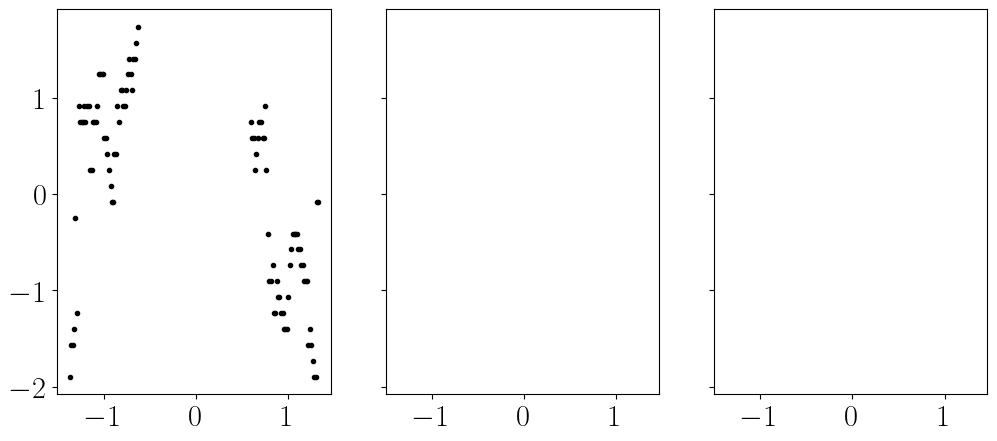

In [10]:
import matplotlib.pyplot as plt

# Number of outputs (columns)
D = Y_std.shape[1]

# Create 1x2 grid
fig, axes = plt.subplots(1, D, figsize=(12, 5), sharex=True, sharey=True)

for d in range(D):
    ax = axes[d]
    
    # Plot the true values
    ax.plot(X_std[:, 0], Y_std[:, d], 'k.', label='True Y', markersize=6, zorder=10)
    
    # Plot MOGP predictions with uncertainty
    ax.plot(X_std[:, 0], mu_mogp[:, d], 'b-', label='MOGP mean')
    ax.fill_between(
        np.arange(len(mu_mogp)),
        mu_mogp[:, d] - 2*std_mogp[:, d],
        mu_mogp[:, d] + 2*std_mogp[:, d],
        color='blue', alpha=0.2
    )
    
    # Plot MORCGP predictions with uncertainty
    ax.plot(X_std[:, 0], mu_morcgp[:, d], 'r-', label='MORCGP mean')
    # ax.fill_between(
    #     np.arange(len(mu_morcgp)),
    #     mu_morcgp[:, d] - 2*std_morcgp[:, d],
    #     mu_morcgp[:, d] + 2*std_morcgp[:, d],
    #     color='red', alpha=0.2
    # )
    
    ax.set_title(f'Output {d+1}')
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Standardized Y')
    ax.set_xlim(-1.4, -0.6)
    # ax.legend()

plt.tight_layout()
plt.show()


In [300]:
true_mu_mogp = scaler_Y.inverse_transform(mu_mogp)
true_mu_morcgp = scaler_Y.inverse_transform(mu_morcgp)

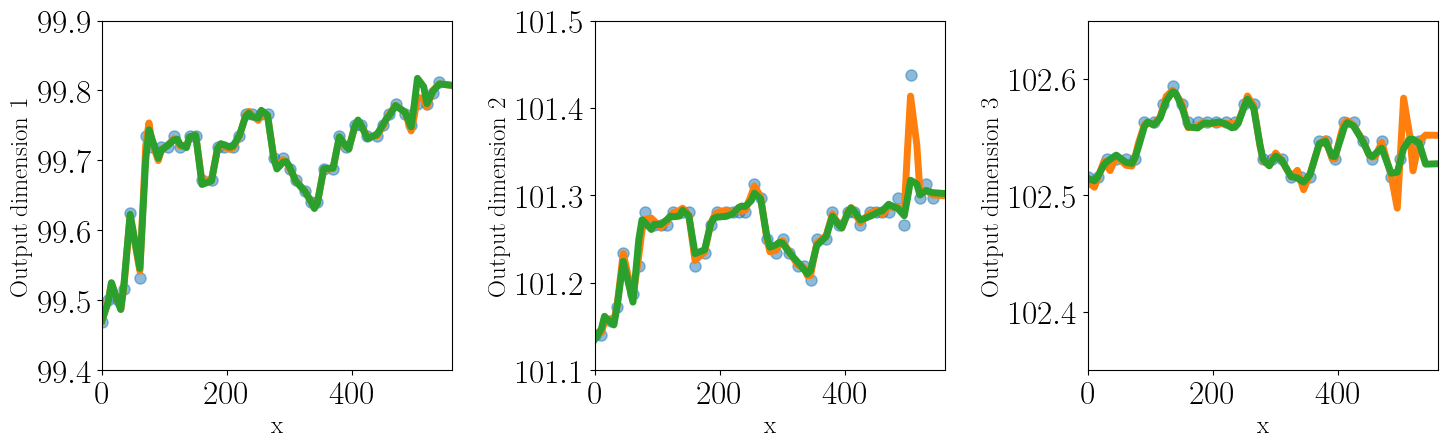

In [314]:
import matplotlib.pyplot as plt

x_flat = x.flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define y-limits for each subplot
y_limits = [
    [99.4, 99.9],   # ylim for first plot
    [101.1, 101.5],   # ylim for second plot
    [102.35, 102.65]    # ylim for third plot
]

# Common x-limit
x_limit = [x_flat.min(), 560]

for i in range(3):
    axes[i].plot(x_flat, Y[:, i], 'o', label='Y', alpha=0.5)
    axes[i].plot(x_flat, true_mu_mogp[:, i], '-', label='mu_mogp')
    axes[i].plot(x_flat, true_mu_morcgp[:, i], '-', label='mu_morcgp')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel(f'Output dimension {i+1}')
    axes[i].set_ylim(y_limits[i])    # different y-limits per subplot
    axes[i].set_xlim(x_limit)        # same x-limit for all

plt.tight_layout()
plt.show()


In [ ]:
print(Y[44, 1])

101.4375


In [ ]:
print(Y[44, 1])

101.4375


In [367]:
print(X_std.min())
print(X_std.max())

-1.3674765326157958
1.3274730115399243


In [369]:
X_std.flatten()

array([-1.367, -1.354, -1.347, -1.333, -1.327, -1.32 , -1.306, -1.285,
       -1.272, -1.266, -1.259, -1.245, -1.238, -1.225, -1.211, -1.204,
       -1.198, -1.184, -1.177, -1.163, -1.15 , -1.129, -1.116, -1.109,
       -1.102, -1.089, -1.082, -1.068, -1.055, -1.048, -1.041, -1.027,
       -1.021, -1.007, -0.993, -0.987, -0.973, -0.966, -0.959, -0.946,
       -0.926, -0.912, -0.905, -0.898, -0.885, -0.864, -0.851, -0.836,
       -0.83 , -0.817, -0.81 , -0.803, -0.789, -0.769, -0.755, -0.749,
       -0.742, -0.728, -0.708, -0.694, -0.687, -0.68 , -0.667, -0.66 ,
       -0.646, -0.632,  0.593,  0.606,  0.612,  0.626,  0.633,  0.64 ,
        0.653,  0.653,  0.674,  0.687,  0.694,  0.701,  0.715,  0.721,
        0.735,  0.749,  0.756,  0.763,  0.776,  0.783,  0.789,  0.796,
        0.81 ,  0.83 ,  0.844,  0.851,  0.857,  0.871,  0.878,  0.892,
        0.905,  0.912,  0.919,  0.926,  0.932,  0.946,  0.952,  0.966,
        0.973,  0.987,  0.993,  1.   ,  1.014,  1.034,  1.048,  1.055,
      

In [12]:
x_tester = np.linspace(-1.4, 1.4, 2000).reshape(-1, 1)
x_tester_rescaled = scaler_X.inverse_transform(x_tester).reshape(-1,1)

test_mogp, test_mogp_var = mogp.predict(x_tester)
test_mogp_std = np.sqrt(test_mogp_var + mogp.noise)
test_morcgp, test_morcgp_var = morcgp.predict(x_tester)
test_morcgp_std = np.sqrt(test_morcgp_var + morcgp.noise_var)

test_mogp_rescaled = scaler_Y.inverse_transform(test_mogp)
test_mogp_std_rescaled = test_mogp_std * scaler_Y.scale_
test_morcgp_rescaled = scaler_Y.inverse_transform(test_morcgp)
test_morcgp_std_rescaled = test_morcgp_std * scaler_Y.scale_

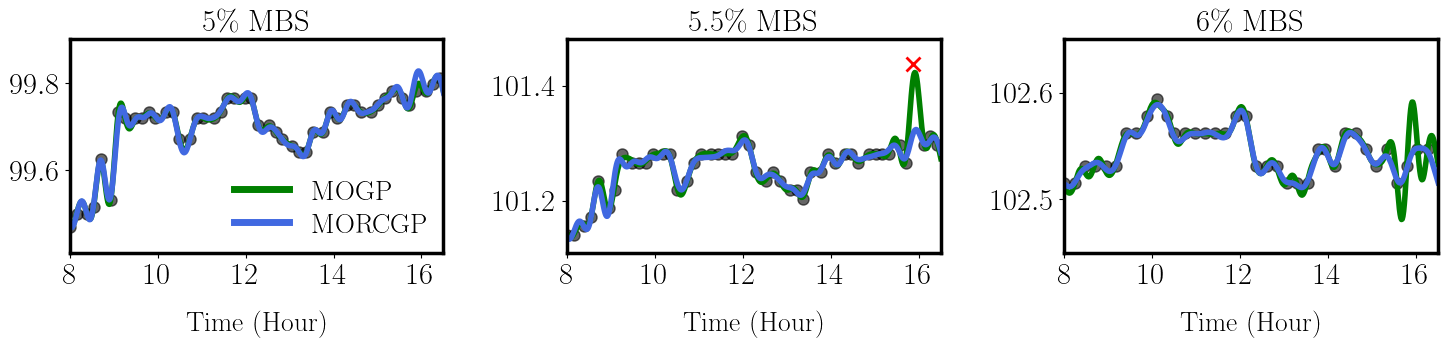

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.41, 99.9],     # ylim for first plot
    [101.11, 101.48],  # ylim for second plot
    [102.45, 102.65]   # ylim for third plot
]

# Common x-limit
x_limit = [x_flat.min(), 545]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    # mask out the special red point for subplot 2
    if i == 1:
        mask = np.arange(len(x_flat)) != 61
        axes[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black')
        axes[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
    else:
        axes[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black')
    
    # other lines
    axes[i].plot(x_tester_rescaled, test_mogp_rescaled[:, i], '-', color='Green', linewidth=4)
    axes[i].plot(x_tester_rescaled, test_morcgp_rescaled[:, i], '-', color='RoyalBlue', linewidth=4)
    
    # Only set x-label for middle subplot
    axes[i].set_xlabel('Time (Hour)', fontsize=20, labelpad=15)

    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_title(titles[i], fontsize=22)

    # Thicker borders
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)


# Add custom legend to the leftmost subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,    # shorter line in legend
    handleheight=1,    # vertical size of the line
    labelspacing=0.2,  # space between labels
    borderpad=0.01      # padding between legend and content
)
axes[1].plot(x_flat[61], Y[61, 1], 'x', color='red')

plt.tight_layout()
plt.show()

# fig.savefig("./FNCL.pdf", format='pdf', bbox_inches='tight')

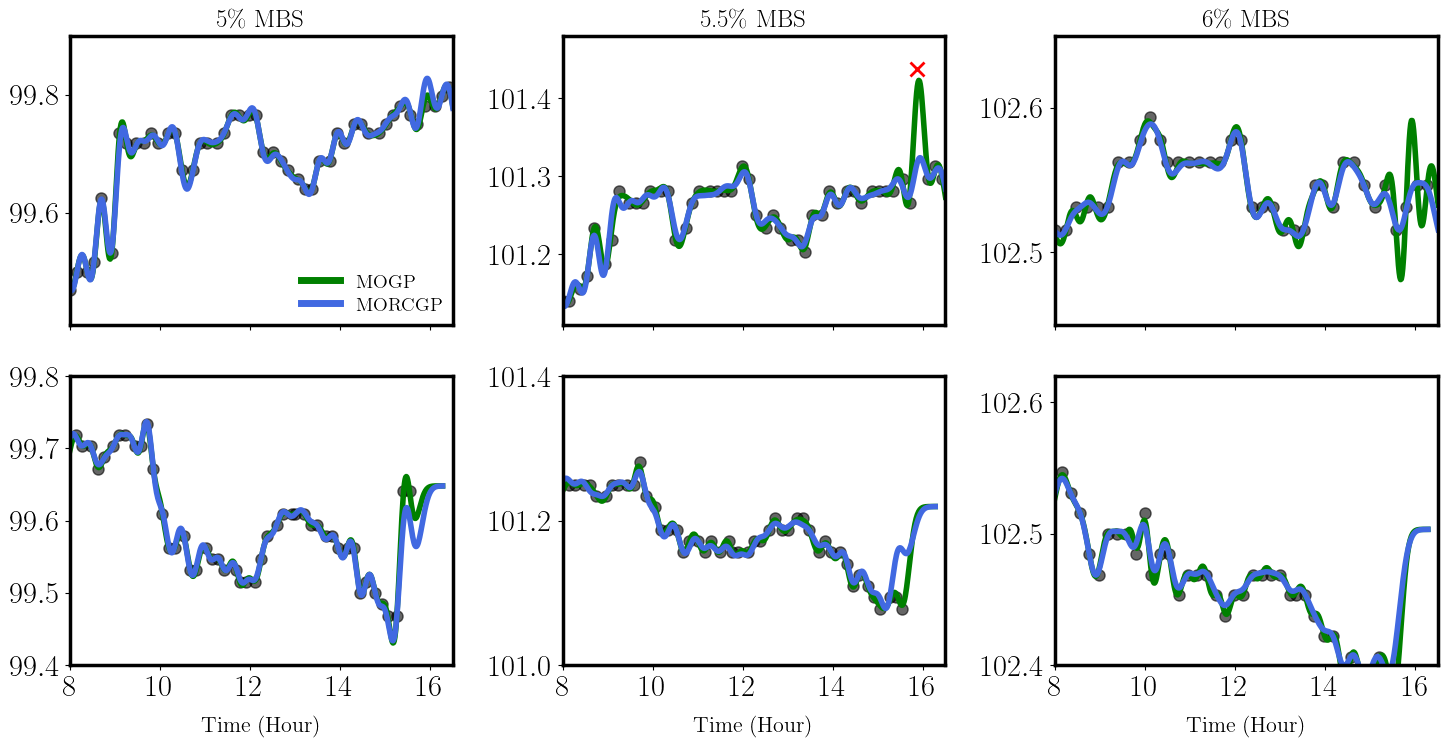

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # taller figure for 2 rows

# ---------- Top row settings ----------
# Define y-limits for top row
y_limits_top = [
    [99.41, 99.9],
    [101.11, 101.48],
    [102.45, 102.65]
]

# Common x-limit for top row
x_limit_top = [x_flat.min(), 545]

# Titles for top row
titles_top = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

# ---------- Bottom row settings ----------
# Define y-limits for bottom row
y_limits_bottom = [
    [99.4, 99.8],      # change as needed
    [101.0, 101.4],     # change as needed
    [102.4, 102.62]      # change as needed
]

# Common x-limit for bottom row
x_limit_bottom = [1430, 2050]  # example new x-range

# Titles for bottom row
titles_bottom = [r'5\% MBS (new)', r'5.5\% MBS (new)', r'6\% MBS (new)']

# Tick labels (same for both rows)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# ---------- Plotting function ----------
def plot_row(ax_row, y_limits, x_limit, titles=None, show_xlabel=True, show_xticks=True):
    x_start, x_end = x_limit
    tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

    for i in range(3):
        # mask out special red point for middle plot
        if i == 1:
            mask = np.arange(len(x_flat)) != 61
            ax_row[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black')
            ax_row[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
        else:
            ax_row[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black')

        # Other lines
        ax_row[i].plot(x_tester_rescaled, test_mogp_rescaled[:, i], '-', color='Green', linewidth=4)
        ax_row[i].plot(x_tester_rescaled, test_morcgp_rescaled[:, i], '-', color='RoyalBlue', linewidth=4)

        # X-axis labels
        if show_xlabel:
            ax_row[i].set_xlabel('Time (Hour)', fontsize=16, labelpad=10)
        else:
            ax_row[i].set_xlabel('')

        # X-axis tick labels
        ax_row[i].set_xticks(tick_positions)
        if show_xticks:
            ax_row[i].set_xticklabels(tick_labels)
        else:
            ax_row[i].set_xticklabels([])

        # Y-limits and X-limits
        ax_row[i].set_ylim(y_limits[i])
        ax_row[i].set_xlim(x_limit)

        # Title
        if titles is not None:
            ax_row[i].set_title(titles[i], fontsize=18)

        # Thicker borders
        for spine in ax_row[i].spines.values():
            spine.set_linewidth(2.5)

# ---------- Plotting ----------
# Top row: no x-labels, no tick labels
plot_row(axes[0], y_limits_top, x_limit_top, titles=titles_top, show_xlabel=False, show_xticks=False)

# Bottom row: show x-labels and tick labels
plot_row(axes[1], y_limits_bottom, x_limit_bottom, titles=None, show_xlabel=True, show_xticks=True)

# Add custom legend to top-left subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0, 0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=14,
    frameon=False,
    handlelength=2,
    handleheight=1,
    labelspacing=0.2,
    borderpad=0.01
)

plt.tight_layout()
plt.show()

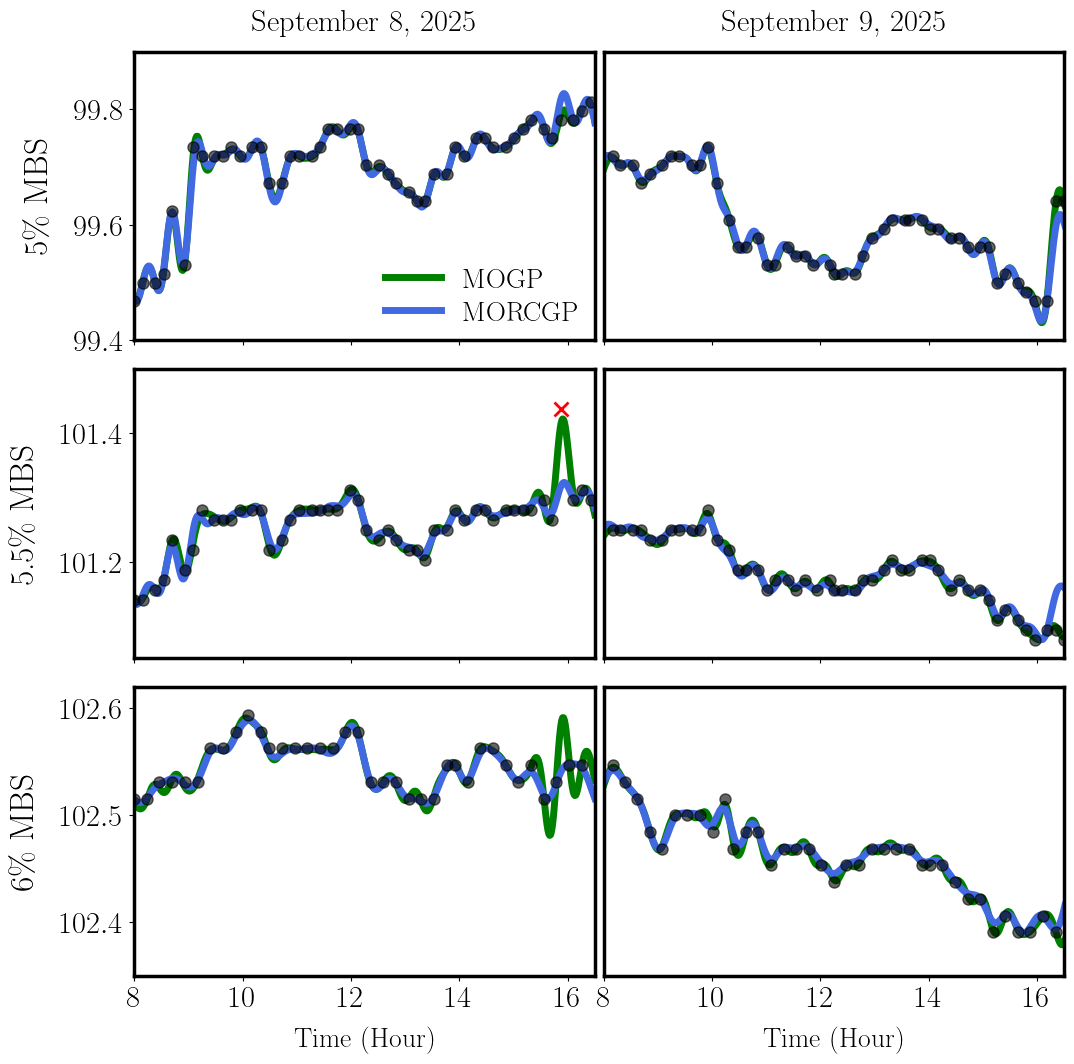

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create 3x2 subplots (transposed layout)
fig, axes = plt.subplots(
    3, 2, figsize=(12, 12),
    gridspec_kw={'wspace': 0.02, 'hspace': 0.1}  # decrease horizontal space, keep some vertical spacing
)

# ---------- Settings for transposed layout ----------

# # Y-limits for each subplot
# y_limits = [
#     [99.41, 99.9], [99.4, 99.8],
#     [101.11, 101.48], [101.0, 101.4],
#     [102.45, 102.65], [102.4, 102.62]
# ]

# X-limits for each subplot
x_limits = [
    [x_flat.min(), 545], [1430, x_flat.max()],
    [x_flat.min(), 545], [1430, x_flat.max()],
    [x_flat.min(), 545], [1430, x_flat.max()]
]

# Tick labels (same for all)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Compute common y-limits per row
y_limits_rows = [
    [99.4, 99.9],  # Row 0
    [101.05, 101.5],  # Row 1
    [102.35, 102.62]   # Row 2
]

# Titles for left column
y_titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

def plot_subplot(ax, idx):
    x_start, x_end = x_limits[idx]
    tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

    # Mask special red point for middle column
    col_idx = idx // 2
    if col_idx == 1 and idx % 2 == 0:
        mask = np.arange(len(x_flat)) != 61
        ax.plot(x_flat[mask], Y[mask, col_idx], 'o', alpha=0.6, color='black', zorder=10)
        ax.plot(x_flat[61], Y[61, col_idx], 'x', color='red', markersize=10, mew=2)
    else:
        ax.plot(x_flat, Y[:, col_idx], 'o', alpha=0.6, color='black', zorder=10)

    # Other lines
    ax.plot(x_tester_rescaled, test_mogp_rescaled[:, col_idx], '-', color='Green', linewidth=5)
    ax.plot(x_tester_rescaled, test_morcgp_rescaled[:, col_idx], '-', color='RoyalBlue', linewidth=5)

    # X-axis labels for bottom row only
    if idx >= 4:
        ax.set_xlabel('Time (Hour)', fontsize=20, labelpad=10)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    else:
        ax.set_xlabel('')
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([])

    # Common y-limits per row
    row = idx // 2
    ax.set_ylim(y_limits_rows[row])
    ax.set_xlim(x_limits[idx])

    # Add y-axis labels for left column only
    if idx % 2 == 0:  # left column
        ax.set_ylabel(y_titles[row], fontsize=24, labelpad=15)
    else:
        ax.set_yticklabels([])
        ax.yaxis.set_ticks([])

    # Thicker borders
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

# ---------- Plotting all subplots ----------
for i in range(6):
    row, col = divmod(i, 2)  # 3x2 layout
    plot_subplot(axes[row, col], i)

# Define titles for each column
column_titles = ['September 8, 2025', 'September 9, 2025']

# Set titles for the top row
for col in range(2):
    axes[0, col].set_title(column_titles[col], fontsize=22, pad=15)  # pad moves title away from plot

# Add custom legend to top-left subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0, 0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,
    handleheight=1,
    labelspacing=0.2,
    borderpad=0.01
)

# plt.tight_layout()
plt.show()

fig.savefig("./FNCL_2days.pdf", format='pdf', bbox_inches='tight')


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.2, 99.9],     # ylim for first plot
    [100.9, 101.48],  # ylim for second plot
    [102.35, 102.65]   # ylim for third plot
]

# Common x-limit
x_limit = [x_flat.min(), x_flat.max()]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    # mask out the special red point for subplot 2
    if i == 1:
        mask = np.arange(len(x_flat)) != 61
        axes[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black')
        axes[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
    else:
        axes[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black')
    
    # plot mean predictions
    axes[i].plot(x_tester_rescaled, test_mogp_rescaled[:, i], '-', color='Green', linewidth=4)
    axes[i].plot(x_tester_rescaled, test_morcgp_rescaled[:, i], '-', color='RoyalBlue', linewidth=4)
    
    # plot uncertainty bands (±1 std by default, can change to 2*std for 95% CI)
    axes[i].fill_between(
        x_tester_rescaled.flatten(),
        test_mogp_rescaled[:, i] - test_mogp_std_rescaled[:, i],
        test_mogp_rescaled[:, i] + test_mogp_std_rescaled[:, i],
        color='Green',
        alpha=0.2
    )
    axes[i].fill_between(
        x_tester_rescaled.flatten(),
        test_morcgp_rescaled[:, i] - test_morcgp_std_rescaled[:, i],
        test_morcgp_rescaled[:, i] + test_morcgp_std_rescaled[:, i],
        color='RoyalBlue',
        alpha=0.2
    )
    
    # Only set x-label for middle subplot
    axes[i].set_xlabel('Time (Hour)', fontsize=20, labelpad=15)

    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_title(titles[i], fontsize=22)

    # Thicker borders
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)



# Add custom legend to the leftmost subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,    # shorter line in legend
    handleheight=1,    # vertical size of the line
    labelspacing=0.2,  # space between labels
    borderpad=0.01      # padding between legend and content
)
axes[1].plot(x_flat[61], Y[61, 1], 'x', color='red')

plt.tight_layout()
plt.show()

# fig.savefig("./FNCL.pdf", format='pdf', bbox_inches='tight')

NameError: name 'x' is not defined

In [426]:

# Save all arrays in one file
np.savez(
    r"C:\Users\joshu\Desktop\uni\thesis_UCL\predictions\FNCL_both_days.npz",
    x_flat=x_flat,
    Y=Y,
    x_tester_rescaled=x_tester_rescaled,
    test_mogp_rescaled=test_mogp_rescaled,
    test_mogp_std_rescaled=test_mogp_std_rescaled,
    test_morcgp_rescaled=test_morcgp_rescaled,
    test_morcgp_std_rescaled=test_morcgp_std_rescaled,
)

print("Data saved to FNCL_predictions.npz")


Data saved to FNCL_predictions.npz


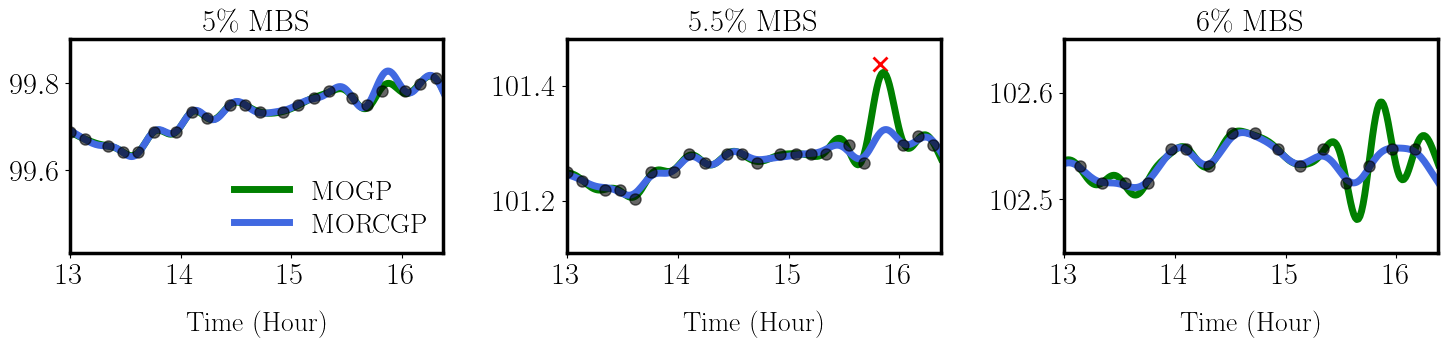

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.41, 99.9],     # ylim for first plot
    [101.11, 101.48],  # ylim for second plot
    [102.45, 102.65]   # ylim for third plot
]

# Common x-limit
x_limit = [300, 545]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['13', '14', '15', '16']
tick_positions_fraction = np.linspace(0, 8/9, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    # mask out the special red point for subplot 2
    if i == 1:
        mask = np.arange(len(x_flat)) != 61
        axes[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black', zorder=10)
        axes[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
    else:
        axes[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black', zorder=10)
    
    # other lines
    axes[i].plot(x_tester_rescaled, test_mogp_rescaled[:, i], '-', color='Green', linewidth=5)
    axes[i].plot(x_tester_rescaled, test_morcgp_rescaled[:, i], '-', color='RoyalBlue', linewidth=5)
    
    # Only set x-label for middle subplot
    axes[i].set_xlabel('Time (Hour)', fontsize=20, labelpad=15)

    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_title(titles[i], fontsize=22)

    # Thicker borders
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)


# Add custom legend to the leftmost subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MO-RCGP')
axes[0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,    # shorter line in legend
    handleheight=1,    # vertical size of the line
    labelspacing=0.2,  # space between labels
    borderpad=0.01      # padding between legend and content
)
axes[1].plot(x_flat[61], Y[61, 1], 'x', color='red')

plt.tight_layout()
plt.show()

fig.savefig("./FNCL.pdf", format='pdf', bbox_inches='tight')

Trashy stuff

In [288]:
true_mu_mogp = scaler_Y.inverse_transform(mu_mogp)
true_mu_morcgp = scaler_Y.inverse_transform(mu_morcgp)
x_test = scaler_X.inverse_transform(X_std_test)

In [289]:
x_test.shape

(2000, 1)

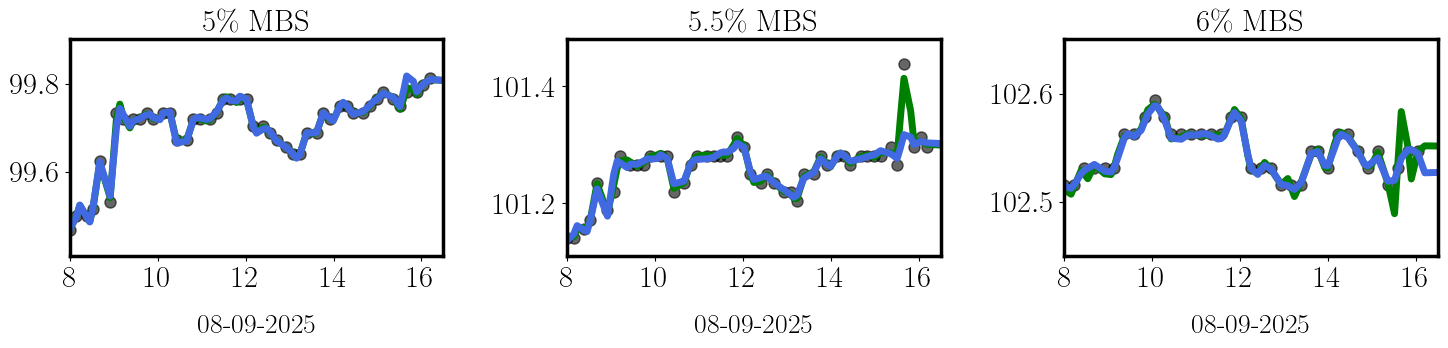

In [336]:
import matplotlib.pyplot as plt
import numpy as np

x_flat = x.flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.41, 99.9],    # ylim for first plot
    [101.11, 101.48],  # ylim for second plot
    [102.45, 102.65] # ylim for third plot
]

# Common x-limit
x_limit = [x_flat.min(), 560]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    axes[i].plot(x_flat, Y[:, i], 'o', label='Y', alpha=0.6, color='black')
    axes[i].plot(x_flat, true_mu_mogp[:, i], '-', label='mu_mogp', color='Green')
    axes[i].plot(x_flat, true_mu_morcgp[:, i], '-', label='mu_morcgp', color='RoyalBlue')
    
    # Only set x-label for the middle subplot
    if True:
    # if i == 1:
        axes[i].set_xlabel('08-09-2025', fontsize=20, labelpad=15)  # larger font and more padding
    
    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    
    # Set title with custom font size
    axes[i].set_title(titles[i], fontsize=22)
    
    # Make all borders thicker
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)  # increase thickness

plt.tight_layout()
plt.show()


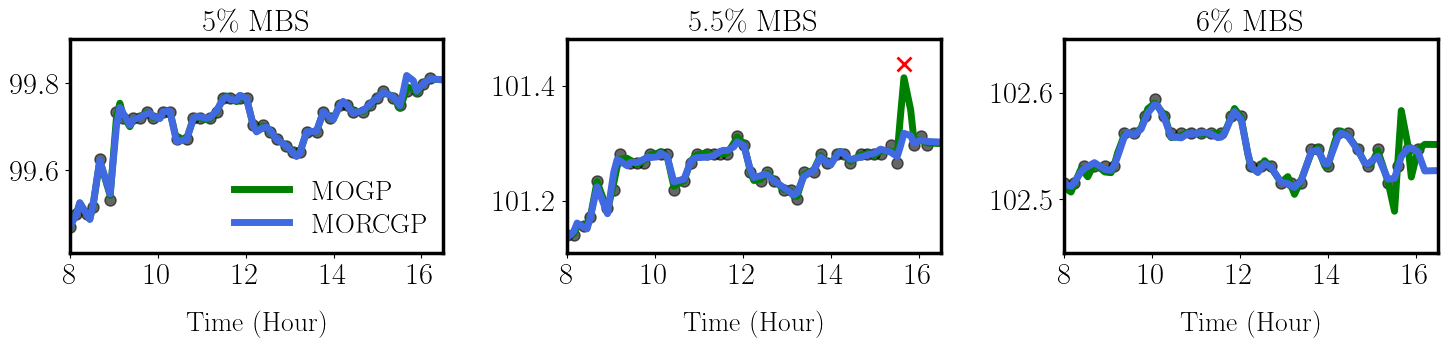

In [365]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.41, 99.9],     # ylim for first plot
    [101.11, 101.48],  # ylim for second plot
    [102.45, 102.65]   # ylim for third plot
]

# Common x-limit
x_limit = [x_flat.min(), 560]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    # mask out the special red point for subplot 2
    if i == 1:
        mask = np.arange(len(x_flat)) != 61
        axes[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black')
        axes[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
    else:
        axes[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black')
    
    # other lines
    axes[i].plot(x_flat, true_mu_mogp[:, i], '-', color='Green')
    axes[i].plot(x_flat, true_mu_morcgp[:, i], '-', color='RoyalBlue')
    
    # Only set x-label for middle subplot
    axes[i].set_xlabel('Time (Hour)', fontsize=20, labelpad=15)

    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_title(titles[i], fontsize=22)

    # Thicker borders
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)


# Add custom legend to the leftmost subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,    # shorter line in legend
    handleheight=1,    # vertical size of the line
    labelspacing=0.2,  # space between labels
    borderpad=0.01      # padding between legend and content
)
axes[1].plot(x_flat[61], Y[61, 1], 'x', color='red')

plt.tight_layout()
plt.show()

fig.savefig("./FNCL.pdf", format='pdf', bbox_inches='tight')

IndexError: boolean index did not match indexed array along axis 0; size of axis is 136 but size of corresponding boolean axis is 2000

Error in callback <function _draw_all_if_interactive at 0x000001F9A0EC1E40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

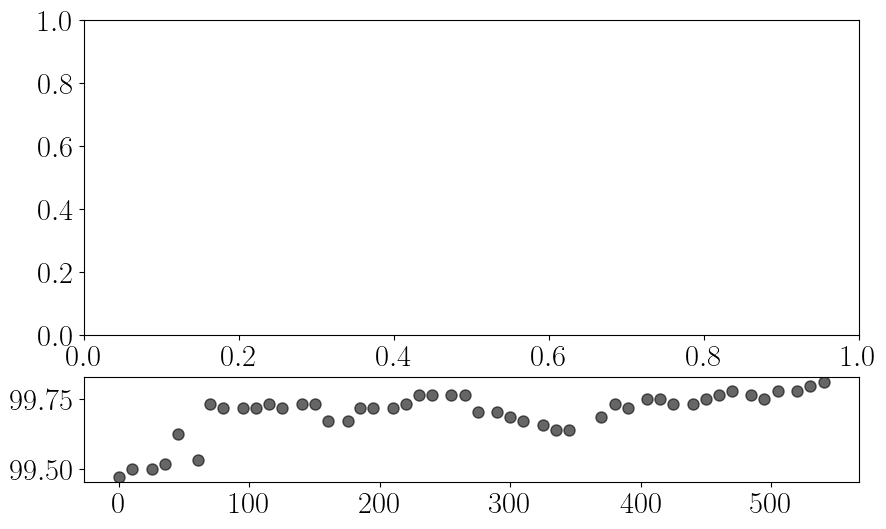

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make top plot twice as large as bottom plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})

# Flatten all masks
mask1 = (x_test < 1000).flatten()
mask2 = ((x_test >= 1000) & (x_test < 2500)).flatten()
mask3 = (x_test >= 2500).flatten()

mask1_x = (x < 1000).flatten()
mask2_x = ((x >= 1000) & (x < 2500)).flatten()
mask3_x = (x >= 2500).flatten()

# Define masks for looping
masks = [mask1, mask2, mask3]
masks_x = [mask1_x, mask2_x, mask3_x]

# Define custom tick labels and their numeric values
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))  # relative positions along x-axis

# Define y-limits for each row (outputs)
y_limits = [(99.4, 99.9), (101.1, 101.52), (102.3, 102.7)]  # example values for row 0, 1, 2

# Index of the special point
special_idx = 44

for i in range(2):  # Rows
    for j in range(1):  # Only one column now
        axes_to_use = axes[1 - i]  # 0->1, 1->0

        # Mask out the special index
        mask_to_plot = masks_x[j].copy()
        mask_to_plot[special_idx] = False  # Exclude the special point

        axes_to_use.plot(x[mask_to_plot], Y[mask_to_plot, i], 'o', color='black', alpha=0.6)
        axes_to_use.plot(x_test[masks[j]], true_mu_mogp[masks[j], i], '-', color='Green')
        axes_to_use.plot(x_test[masks[j]], true_mu_morcgp[masks[j], i], '-', color='RoyalBlue')

        # Set x-axis limits
        x_min = x_test[masks[j]].min()
        x_max = x_test[masks[j]].max()
        axes_to_use.set_xlim(x_min, 540)

        # Set y-axis limits for this row
        axes_to_use.set_ylim(y_limits[i])

        # Show x-axis labels only for bottom row
        if axes_to_use != axes[-1]:  # If not bottom row, hide labels
            axes_to_use.set_xlabel('')
            axes_to_use.tick_params(labelbottom=False)
        else:  # Bottom row
            tick_positions = x_min + tick_positions_fraction * (x_max - x_min)
            axes_to_use.set_xticks(tick_positions)
            axes_to_use.set_xticklabels(tick_labels)

# Plot only the special point as a red cross
axes[0].plot(x[special_idx, 0], Y[special_idx, 1], 'x', color='red', markeredgewidth=3)

axes[0].set_yticks([101.2, 101.4])
axes[1].set_yticks([99.5, 99.8])

fig.subplots_adjust(hspace=0.1)
plt.show()

In [233]:
print(Y[44, 1])

101.4375


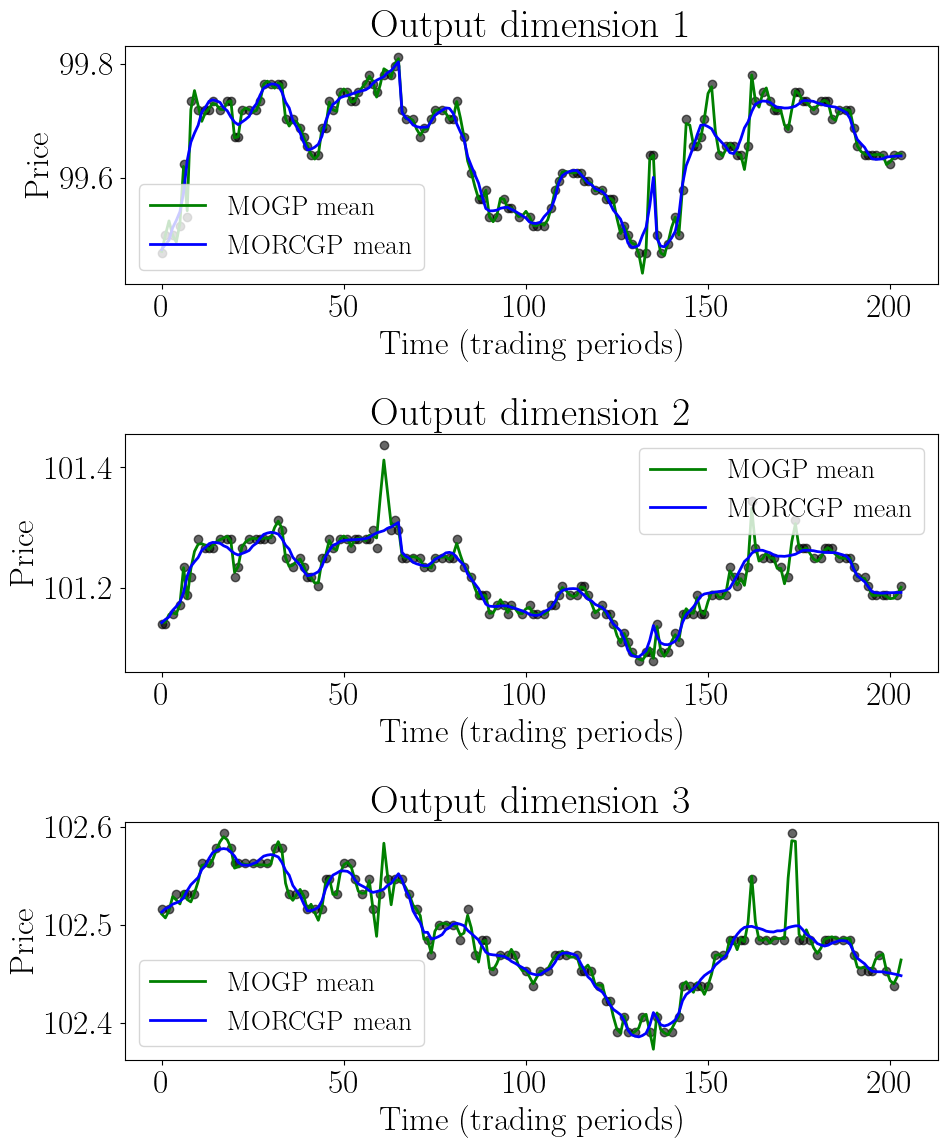

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: x is datetime, Y is prices
# Let's assume x is a pandas DatetimeIndex or array of datetimes
# Keep only trading times
trading_times = x  # x already has only the trading timestamps

# Convert x to an ordinal trading index
x_index = np.arange(len(trading_times))

fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # 3 rows, 1 column

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(x_index, Y[:, i], 'o', color='black', markersize=6, alpha=0.6)
    
    # Plot MOGP predictions
    ax.plot(x_index, true_mu_mogp[:, i], '-', color='green', linewidth=2, label='MOGP mean')
    
    # Plot MORCGP predictions
    ax.plot(x_index, true_mu_morcgp[:, i], '-', color='blue', linewidth=2, label='MORCGP mean')
    
    ax.set_title(f'Output dimension {i+1}')
    ax.set_xlabel('Time (trading periods)')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()
